In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pickle
import numpy as np

from sklearn.model_selection import train_test_split


pickle_in = open("/content/gdrive/My Drive/CBIS_DDSM_IMAGES/X_normal_mammo.pickle","rb")
normal = pickle.load(pickle_in)
normal = normal[:2000]

pickle_in = open("/content/gdrive/My Drive/CBIS_DDSM_IMAGES/X_benigncalc_mammo.pickle","rb")
benigncalc = pickle.load(pickle_in)

pickle_in = open("/content/gdrive/My Drive/CBIS_DDSM_IMAGES/X_benignmass_mammo.pickle","rb")
benignmass = pickle.load(pickle_in)

pickle_in = open("/content/gdrive/My Drive/CBIS_DDSM_IMAGES/X_malignantcalc_mammo.pickle","rb")
malignantcalc = pickle.load(pickle_in)



pickle_in = open("/content/gdrive/My Drive/CBIS_DDSM_IMAGES/X_malignantmass_mammo.pickle","rb")
malignantmass = pickle.load(pickle_in)



print(normal.shape)
print(benignmass.shape)
print(benigncalc.shape)

print(malignantcalc.shape)
print(malignantmass.shape)







(2000, 128, 128, 3)
(1911, 128, 128, 3)
(2103, 128, 128, 3)
(1463, 128, 128, 3)
(1812, 128, 128, 3)


In [ ]:
import cv2 as cv
def improve_contrast_image_using_clahe(bgr_image: np.array) -> np.array:
    hsv = cv.cvtColor(bgr_image, cv.COLOR_BGR2HSV)
    hsv_planes = cv.split(hsv)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hsv_planes[2] = clahe.apply(hsv_planes[2])
    hsv = cv.merge(hsv_planes)
    return cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

In [ ]:
from sklearn.utils import shuffle

label_normal = [0]*2000

label_benigncalc = [1]*1911
label_benignmass = [2]*2103


label_malignantcalc = [3]*1463
label_malignantmass = [4]*1812

# y = np.concatenate((y1,y2,y3),axis = 0)
train_label = np.concatenate((label_normal, label_benigncalc, label_benignmass, label_malignantcalc, label_malignantmass),axis = 0)
print(len(train_label))

train_data = np.concatenate((normal, benigncalc,benignmass,malignantcalc,malignantmass), axis = 0)

test_data = np.concatenate((normal[:200], benigncalc[:191],benignmass[:210],malignantcalc[:143],malignantmass[:181]), axis = 0)
test_label = np.concatenate((label_normal[:200], label_benigncalc[:191], label_benignmass[:210], label_malignantcalc[:143], label_malignantmass[:181]), axis = 0)
del(normal)
del(benigncalc)
del(benignmass)
del(malignantcalc)
del(malignantmass)


X_mod = []
for i in range(len(train_data)):
  X_mod.append(improve_contrast_image_using_clahe(train_data[i]))
X_mod = np.array(X_mod)
train_data = X_mod

X_mod = []
for i in range(len(test_data)):
  X_mod.append(improve_contrast_image_using_clahe(test_data[i]))
X_mod = np.array(X_mod)
test_data = X_mod

train_data , train_label = shuffle(train_data , train_label)
test_data , test_label = shuffle(test_data , test_label)

print(train_data.shape)
print(train_label.shape)
print(train_label)

9289
(9289, 128, 128, 3)
(9289,)
[0 1 0 ... 1 0 4]


In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_label),
                                                 train_label)
class_weights = dict(enumerate(class_weights))

In [ ]:
import os
import csv 
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout,Dense,BatchNormalization,SpatialDropout2D
from keras.regularizers import l2
import pandas as pd
from tqdm import tqdm
from glob import glob
from keras.layers import *
from keras.models import *
from keras.utils import *
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import keras.backend as K
import functools 
from keras.optimizers import SGD
import numpy as np
import os

from keras.optimizers import Adam
from keras import optimizers

# Sys
import warnings
# Keras Core
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Input, Dropout, Dense, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.layers import Add
from keras import regularizers
from keras import initializers
from keras.models import Model

# Backend
from keras import backend as K


def Network(width, height, depth, classes, channels=1):
  
  # dense_net = tf.keras.applications.densenet.DenseNet121()
  # x = dense_net.layers[-2].output
  # output = Dense(units=classes, activation='softmax')(x)
  # model = Model(inputs=dense_net.input, outputs=output)
  # for layer in model.layers[:-7]:
  #   layer.trainable = False
  # model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  # return model
  # initialize the model along with the input shape to be
  # "channels last" and the channels dimension itself
  model = Sequential()
  pad = 'same'
  inputShape = (height, width, depth)
  chanDim = -1

  # if we are using "channels first", update the input shape
  # and channels dimension
  if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

  #       block 1
  model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding=pad, input_shape=inputShape))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=16, kernel_size=(2, 2), strides=2))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Dropout(0.2))
  model.add(Activation("relu"))

  #     block 2
  model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=32, kernel_size=(2, 2), strides=2))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Dropout(0.2))
  model.add(Activation("relu"))

  #     block 3
  model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=64, kernel_size=(2, 2), strides=2))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Dropout(0.2))
  model.add(Activation("relu"))

  #     block 4
  model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Dropout(0.5))
  model.add(Activation("relu"))

  #     block 5
  model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding=pad))
  model.add(BatchNormalization(axis=chanDim))
  model.add(Dropout(0.5))
  model.add(Activation("relu"))

  model.add(Conv2D(filters=channels, kernel_size=(1, 1), strides=1))

  model.add(Flatten())
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model

# def Network(input_shape, nb_class):

  # model = Sequential()
  # model.add(Conv2D(32, (3, 3), input_shape=(224,224,3)))
  # model.add(Activation('relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))

  # model.add(Conv2D(32, (3, 3)))
  # model.add(Activation('relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))

  # model.add(Conv2D(64, (3, 3)))
  # model.add(Activation('relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))

  # model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
  # model.add(Dense(64))
  # model.add(Activation('relu'))
  # model.add(Dropout(0.5))
  # model.add(Dense(nb_class))
  # model.add(Activation('softmax'))
  # model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
  # return model
# def conv2d_bn(x, nb_filter, num_row, num_col,
#           padding='same', strides=(1, 1), use_bias=False):
#   """
#   Utility function to apply conv + BN. 
#   (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
#   """
#   if K.image_data_format() == 'channels_first':
#     channel_axis = 1
#   else:
#     channel_axis = -1
#   x = Convolution2D(nb_filter, (num_row, num_col),
#                     strides=strides,
#                     padding=padding,
#                     use_bias=use_bias,
#                     kernel_regularizer=regularizers.l2(0.00004),
#                     kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
#   x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
#   x = Activation('relu')(x)
#   return x

# # Recurrent convolutional layer
# def RCL(input, kernel_size, filedepth):
#   if K.image_data_format() == 'channels_first':
#     channel_axis = 1
#   else:
#     channel_axis = -1

#   conv1 = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same',
#                  kernel_regularizer=regularizers.l2(0.00004),
#                  kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(input)

#   stack2 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(conv1)
#   stack2 = Activation('relu')(stack2)

#   RCL = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same', 
#                  kernel_regularizer=regularizers.l2(0.00004),
#                  kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))

#   conv2 = RCL(stack2)
#   stack3 = Add()([conv1, conv2])
#   stack4 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(stack3)
#   stack4 = Activation('relu')(stack4)


#   conv3 = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same',
#                  weights=RCL.get_weights(),
#                  kernel_regularizer=regularizers.l2(0.00004),
#                  kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(stack4)
#   stack5 = Add()([conv1, conv3])
#   stack6 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(stack5)
#   stack6 = Activation('relu')(stack6)


#   conv4 = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same',
#                  weights=RCL.get_weights(),
#                  kernel_regularizer=regularizers.l2(0.00004),
#                  kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(stack6)
#   stack7 = Add()([conv1, conv4])
#   stack8 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(stack7)
#   stack8 = Activation('relu')(stack8)

#   return stack8



# def IRRCNN_base(input):

#   if K.image_data_format() == 'channels_first':
# #     inputShape = (3, 128, 128)
#     channel_axis = 1
#   else:
# #     inputShape = (128, 128, 3)
#     channel_axis = -1

#   # Input Shape is 3 x 128 x 128
#   net = Convolution2D(16, (3, 3), strides=(2,2), padding='valid')(input)
#   net = conv2d_bn(net, 16, 3, 3, padding='valid')
#   net = conv2d_bn(net, 32, 3, 3)

#   net = IRRCNN_block(input)
                 
#   net = conv2d_bn(net, 16, 3, 3, strides=(2,2), padding='valid')
#   net = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
#   net = Dropout(0.5)(net)

#   net = IRRCNN_block(input)
                 
#   net = conv2d_bn(net, 16, 3, 3, strides=(2,2), padding='valid')
#   net = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
#   net = Dropout(0.5)(net)
                 
#   net = IRRCNN_block(input)

#   net = conv2d_bn(net, 16, 3, 3, strides=(2,2), padding='valid')
#   net = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
#   net = Dropout(0.5)(net)
                 
#   net = IRRCNN_block(input)
                 
#   net = conv2d_bn(net, 16, 3, 3, strides=(2,2), padding='valid')
#   net = GlobalAveragePooling2D()(net)
#   net = Dropout(0.5)(net)
#   return net

# def IRCNN_block(input):
#   if K.image_data_format() == 'channels_first':
#     channel_axis = 1
#   else:
#     channel_axis = -1

#   branch_0 = RCL(input, (1, 1), 32)

#   branch_1 = RCL(input, (3, 3), 64)

#   branch_2 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
#   branch_2 = RCL(branch_2, (1, 1), 32)

#   x = concatenate([branch_0, branch_1,branch_2], axis=channel_axis)
#   return x

# def IRRCNN_block(input):
#     if K.image_data_format() == 'channels_first':
#         channel_axis = 1
#     else:
#         channel_axis = -1
#     net= IRCNN_block(input)
#     net1 = Convolution2D(128, (1, 1), padding='valid')(input)
#     net = Add()([net, net1])

#     return net
# def Network(input_shape, nb_class):
#   inputs = Input(shape = input_shape)
#   x = Convolution2D(16, (3, 3), strides=(2,2), padding='valid')(inputs)
#   x = IRRCNN_base(x)
#   x = Dense(units=nb_class, activation='softmax')(x)

#   model = Model(inputs, x, name='IRRCNN')
#   model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#   return model

In [ ]:
# plot confusion matrix

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas.util.testing as tm
from sklearn import metrics
import seaborn as sns
sns.set()

plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save = False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=False)
    if save == True:
      plt.savefig('Confusion Matrix.png', dpi = 900)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import sys


In [ ]:
# test model performance
from datetime import datetime
import matplotlib.pyplot as plt


def test_model(model, test_generator, y_test, class_labels, cm_normalize=True, \
                 print_cm=True):
    
    # BS = 16
    results = dict()
    
    # n = len(testy)// BS

    # testX = testX[:BS*n]
    # testy = testy[:BS*n]

    print('Predicting test data')
    # test_start_time = datetime.now()
    y_pred_original = model.predict_generator(test_generator,verbose=1)
    # y_pred = (y_pred_original>0.5).astype('int')

    y_pred = np.argmax(y_pred_original, axis = 1)
    # y_test = np.argmax(testy, axis= 1)
    #y_test = np.argmax(testy, axis=-1)
    
    test_end_time = datetime.now()
    print('Done \n \n')
    # results['testing_time'] = test_end_time - test_start_time
    # print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
    y_test = y_test.astype(int) # sparse form not categorical
    

    # balanced_accuracy
    from sklearn.metrics import balanced_accuracy_score
    balanced_accuracy = balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
    print('---------------------')
    print('| Balanced Accuracy  |')
    print('---------------------')
    print('\n    {}\n\n'.format(balanced_accuracy))

    
    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    

    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(6,4))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix')
    plt.show()
    

    
    # add the trained  model to the results
    results['model'] = model
    
    return


from keras.callbacks import Callback
class MyLogger(Callback):
  
  def __init__(self, test_generator, y_test, class_labels):
    super(MyLogger, self).__init__()
    self.test_generator = test_generator
    self.y_test = y_test
    self.class_labels = class_labels
    
  def on_epoch_end(self, epoch, logs=None):
    test_model(self.model, self.test_generator, self.y_test, self.class_labels)

In [ ]:
from keras.utils import to_categorical
train_label = to_categorical(train_label, num_classes= 5)
test_label  = to_categorical(test_label, num_classes = 5)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.callbacks import *


train_datagen = ImageDataGenerator(rescale = 1/255)

val_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow(train_data,
                                     train_label, 
                                     batch_size = 16, 
                                     shuffle = True)

val_generator = val_datagen.flow(test_data,
                                 test_label,
                                 batch_size = 16,
                                 shuffle = False)

In [ ]:
def get_callbacks():
    
    filepath = '/content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5'
    callback1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callback2 = MyLogger(val_generator, 
                         y_test = np.argmax(test_label, axis = 1),
                         class_labels = ['Normal','Benigncalc','Benignmass', 'Malignantcalc', 'Malignantmass'])
    
    callback3 = CSVLogger('/content/gdrive/My Drive/CBIS_DDSM_IMAGES/Multiclass_Log_128.csv')

    return [callback1 ,callback2, callback3]

In [ ]:
model = Network(width=128, height=128, depth=3, classes=5)
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 16)        1

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/70
579/580 [============================>.] - ETA: 0s - loss: 0.5094 - accuracy: 0.3374
Epoch 00001: val_accuracy improved from -inf to 0.39035, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
Instructions for updating:
Please use Model.predict, which supports generators.
58/58 [==============================] - 1s 11ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.3926020166232772


---------------------
|      Accuracy      |
---------------------

    0.3902702702702703


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.41      0.85      0.55       200
           1       0.18      0.02      0.03       191
           2       0.33      0.17      0.23       210
           3       0.37      0.41      0.39  

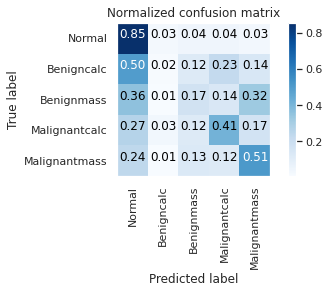

580/580 [==============================] - 20s 34ms/step - loss: 0.5093 - accuracy: 0.3374 - val_loss: 0.8072 - val_accuracy: 0.3904
Epoch 2/70
579/580 [============================>.] - ETA: 0s - loss: 0.4454 - accuracy: 0.4016
Epoch 00002: val_accuracy did not improve from 0.39035
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.28806919391678293


---------------------
|      Accuracy      |
---------------------

    0.2518918918918919


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.07      0.12       200
           1       0.06      0.03      0.04       191
           2       0.33      0.03      0.05       210
           3       0.20      0.79      0.32       143
           4       0.37      0.53      0.44       181

    accuracy                           0.25

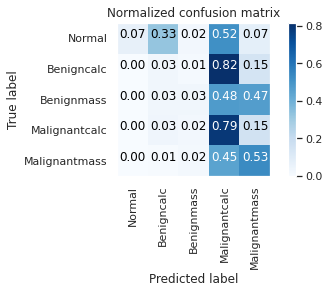

580/580 [==============================] - 16s 28ms/step - loss: 0.4456 - accuracy: 0.4016 - val_loss: 0.5464 - val_accuracy: 0.2522
Epoch 3/70
580/580 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.4053
Epoch 00003: val_accuracy did not improve from 0.39035
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.2279047619047619


---------------------
|      Accuracy      |
---------------------

    0.23675675675675675


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.13      0.23       200
           1       0.21      1.00      0.35       191
           2       0.67      0.01      0.02       210
           3       0.00      0.00      0.00       143
           4       0.00      0.00      0.00       181

    accuracy                           0.24

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


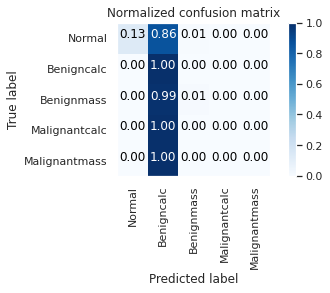

580/580 [==============================] - 16s 28ms/step - loss: 0.4364 - accuracy: 0.4053 - val_loss: 0.5092 - val_accuracy: 0.2368
Epoch 4/70
579/580 [============================>.] - ETA: 0s - loss: 0.4258 - accuracy: 0.4276
Epoch 00004: val_accuracy improved from 0.39035 to 0.40132, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4002129312551054


---------------------
|      Accuracy      |
---------------------

    0.4


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       200
           1       0.39      0.14      0.21       191
           2       0.40      0.18      0.25       210
           3       0.26      0.29      0.28       143
           4       0.34    

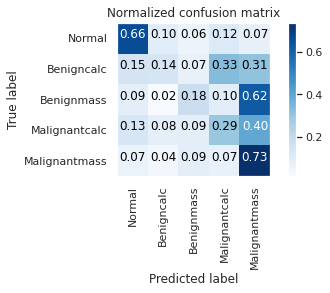

580/580 [==============================] - 17s 30ms/step - loss: 0.4258 - accuracy: 0.4279 - val_loss: 0.4920 - val_accuracy: 0.4013
Epoch 5/70
579/580 [============================>.] - ETA: 0s - loss: 0.4186 - accuracy: 0.4342
Epoch 00005: val_accuracy improved from 0.40132 to 0.41667, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4222720310168171


---------------------
|      Accuracy      |
---------------------

    0.41405405405405404


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.56      0.72      0.63       200
           1       0.55      0.09      0.15       191
           2       0.44      0.20      0.28       210
           3       0.27      0.52      0.36       143
           

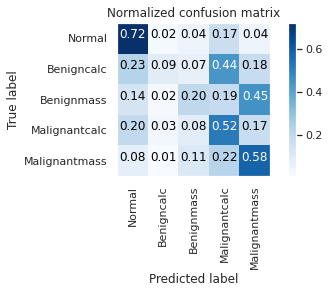

580/580 [==============================] - 17s 30ms/step - loss: 0.4186 - accuracy: 0.4341 - val_loss: 0.4408 - val_accuracy: 0.4167
Epoch 6/70
580/580 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.4448
Epoch 00006: val_accuracy did not improve from 0.41667
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.3906840496674172


---------------------
|      Accuracy      |
---------------------

    0.38594594594594595


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.68      0.43      0.53       200
           1       0.32      0.52      0.40       191
           2       0.48      0.28      0.35       210
           3       0.26      0.48      0.33       143
           4       0.44      0.25      0.32       181

    accuracy                           0.39

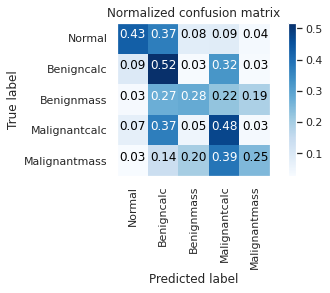

580/580 [==============================] - 16s 28ms/step - loss: 0.4125 - accuracy: 0.4448 - val_loss: 0.4513 - val_accuracy: 0.3849
Epoch 7/70
579/580 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.4501
Epoch 00007: val_accuracy did not improve from 0.41667
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.21951905330503002


---------------------
|      Accuracy      |
---------------------

    0.23675675675675675


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.23      0.97      0.37       200
           1       0.29      0.04      0.07       191
           2       0.28      0.06      0.09       210
           3       1.00      0.01      0.01       143
           4       0.33      0.02      0.03       181

    accuracy                           0.2

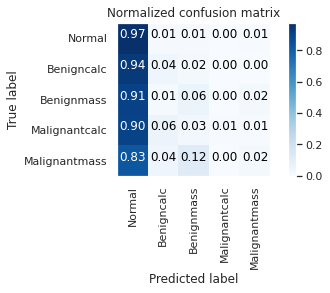

580/580 [==============================] - 16s 28ms/step - loss: 0.4081 - accuracy: 0.4503 - val_loss: 0.7607 - val_accuracy: 0.2379
Epoch 8/70
579/580 [============================>.] - ETA: 0s - loss: 0.4053 - accuracy: 0.4612
Epoch 00008: val_accuracy improved from 0.41667 to 0.42105, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.43203594158293185


---------------------
|      Accuracy      |
---------------------

    0.4227027027027027


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.80      0.51      0.62       200
           1       0.37      0.24      0.29       191
           2       0.43      0.33      0.37       210
           3       0.25      0.57      0.35       143
           

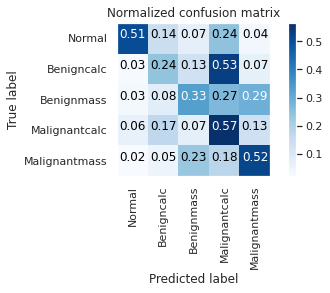

580/580 [==============================] - 17s 30ms/step - loss: 0.4052 - accuracy: 0.4614 - val_loss: 0.4168 - val_accuracy: 0.4211
Epoch 9/70
580/580 [==============================] - ETA: 0s - loss: 0.4037 - accuracy: 0.4621
Epoch 00009: val_accuracy improved from 0.42105 to 0.43311, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4252603162171008


---------------------
|      Accuracy      |
---------------------

    0.4335135135135135


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.44      0.92      0.60       200
           1       0.53      0.19      0.28       191
           2       0.37      0.30      0.33       210
           3       0.37      0.31      0.34       143
           4

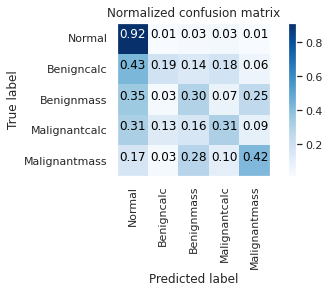

580/580 [==============================] - 17s 30ms/step - loss: 0.4037 - accuracy: 0.4621 - val_loss: 0.4985 - val_accuracy: 0.4331
Epoch 10/70
579/580 [============================>.] - ETA: 0s - loss: 0.4030 - accuracy: 0.4647
Epoch 00010: val_accuracy improved from 0.43311 to 0.48904, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4805143317627481


---------------------
|      Accuracy      |
---------------------

    0.4875675675675676


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.59      0.81      0.68       200
           1       0.48      0.31      0.38       191
           2       0.47      0.32      0.38       210
           3       0.39      0.31      0.34       143
           

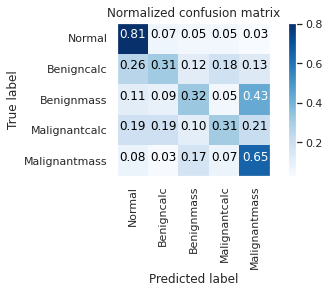

580/580 [==============================] - 18s 30ms/step - loss: 0.4030 - accuracy: 0.4648 - val_loss: 0.4101 - val_accuracy: 0.4890
Epoch 11/70
579/580 [============================>.] - ETA: 0s - loss: 0.3968 - accuracy: 0.4824
Epoch 00011: val_accuracy did not improve from 0.48904
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.42785570977382037


---------------------
|      Accuracy      |
---------------------

    0.43567567567567567


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.49      0.80      0.61       200
           1       0.31      0.19      0.24       191
           2       0.45      0.48      0.46       210
           3       0.32      0.40      0.36       143
           4       0.59      0.28      0.38       181

    accuracy                           0.

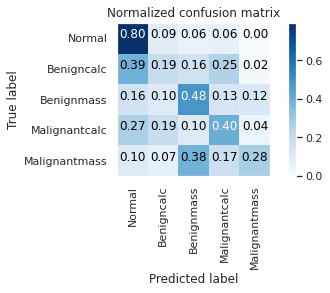

580/580 [==============================] - 17s 29ms/step - loss: 0.3967 - accuracy: 0.4825 - val_loss: 0.4202 - val_accuracy: 0.4375
Epoch 12/70
580/580 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.4776
Epoch 00012: val_accuracy improved from 0.48904 to 0.49342, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4800086913462575


---------------------
|      Accuracy      |
---------------------

    0.49405405405405406


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       200
           1       0.41      0.58      0.48       191
           2       0.47      0.40      0.43       210
           3       0.34      0.21      0.26       143
          

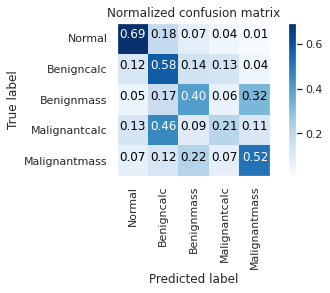

580/580 [==============================] - 18s 30ms/step - loss: 0.3933 - accuracy: 0.4776 - val_loss: 0.4017 - val_accuracy: 0.4934
Epoch 13/70
579/580 [============================>.] - ETA: 0s - loss: 0.3908 - accuracy: 0.4890
Epoch 00013: val_accuracy did not improve from 0.49342
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4461040620309372


---------------------
|      Accuracy      |
---------------------

    0.43891891891891893


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.89      0.56      0.69       200
           1       0.42      0.16      0.23       191
           2       0.52      0.34      0.41       210
           3       0.25      0.52      0.34       143
           4       0.41      0.64      0.50       181

    accuracy                           0.4

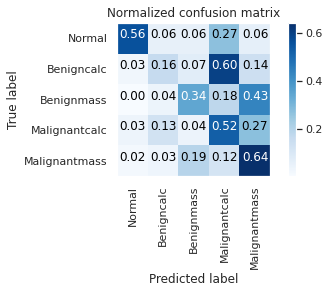

580/580 [==============================] - 17s 29ms/step - loss: 0.3908 - accuracy: 0.4892 - val_loss: 0.4034 - val_accuracy: 0.4397
Epoch 14/70
580/580 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.4955
Epoch 00014: val_accuracy did not improve from 0.49342
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4188030185659991


---------------------
|      Accuracy      |
---------------------

    0.4464864864864865


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.45      0.87      0.60       200
           1       0.46      0.58      0.51       191
           2       0.42      0.49      0.45       210
           3       0.29      0.06      0.10       143
           4       0.62      0.10      0.17       181

    accuracy                           0.45

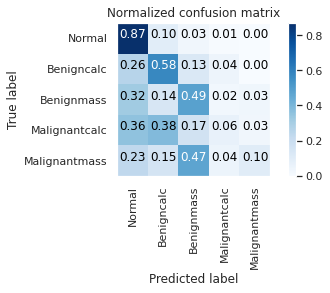

580/580 [==============================] - 17s 29ms/step - loss: 0.3843 - accuracy: 0.4955 - val_loss: 0.4566 - val_accuracy: 0.4474
Epoch 15/70
580/580 [==============================] - ETA: 0s - loss: 0.3806 - accuracy: 0.5006
Epoch 00015: val_accuracy improved from 0.49342 to 0.50219, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4910622709852122


---------------------
|      Accuracy      |
---------------------

    0.5037837837837837


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.53      0.92      0.67       200
           1       0.52      0.41      0.46       191
           2       0.46      0.39      0.42       210
           3       0.40      0.29      0.34       143
           

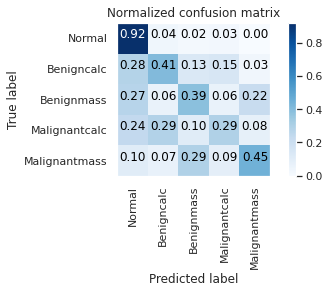

580/580 [==============================] - 18s 31ms/step - loss: 0.3806 - accuracy: 0.5006 - val_loss: 0.3896 - val_accuracy: 0.5022
Epoch 16/70
579/580 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.5190
Epoch 00016: val_accuracy did not improve from 0.50219
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.43064335059423425


---------------------
|      Accuracy      |
---------------------

    0.4118918918918919


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.78      0.59      0.67       200
           1       0.44      0.06      0.10       191
           2       0.51      0.19      0.28       210
           3       0.25      0.69      0.37       143
           4       0.41      0.63      0.50       181

    accuracy                           0.4

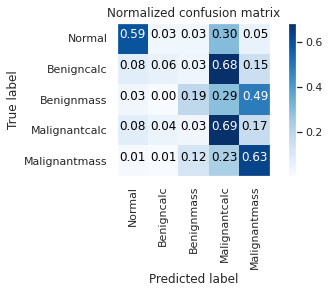

580/580 [==============================] - 17s 29ms/step - loss: 0.3757 - accuracy: 0.5190 - val_loss: 0.4278 - val_accuracy: 0.4145
Epoch 17/70
579/580 [============================>.] - ETA: 0s - loss: 0.3736 - accuracy: 0.5205
Epoch 00017: val_accuracy improved from 0.50219 to 0.51535, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5011443603497637


---------------------
|      Accuracy      |
---------------------

    0.5156756756756756


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.51      0.95      0.67       200
           1       0.63      0.19      0.29       191
           2       0.49      0.55      0.52       210
           3       0.46      0.33      0.38       143
           

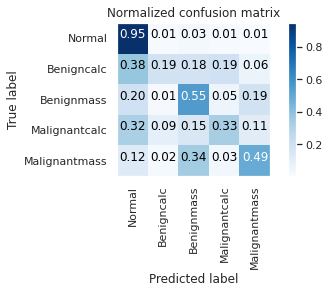

580/580 [==============================] - 18s 30ms/step - loss: 0.3737 - accuracy: 0.5203 - val_loss: 0.4017 - val_accuracy: 0.5154
Epoch 18/70
579/580 [============================>.] - ETA: 0s - loss: 0.3672 - accuracy: 0.5253
Epoch 00018: val_accuracy improved from 0.51535 to 0.55373, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5524117556582628


---------------------
|      Accuracy      |
---------------------

    0.5567567567567567


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       200
           1       0.53      0.42      0.47       191
           2       0.52      0.49      0.50       210
           3       0.43      0.48      0.45       143
           

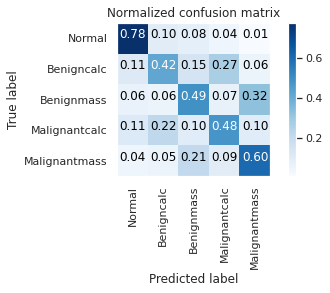

580/580 [==============================] - 18s 30ms/step - loss: 0.3671 - accuracy: 0.5258 - val_loss: 0.3652 - val_accuracy: 0.5537
Epoch 19/70
579/580 [============================>.] - ETA: 0s - loss: 0.3633 - accuracy: 0.5299
Epoch 00019: val_accuracy did not improve from 0.55373
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.3169908820076012


---------------------
|      Accuracy      |
---------------------

    0.33513513513513515


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.30      0.98      0.45       200
           1       0.53      0.20      0.30       191
           2       0.37      0.22      0.28       210
           3       0.39      0.10      0.17       143
           4       0.54      0.07      0.13       181

    accuracy                           0.3

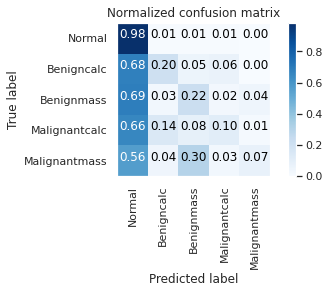

580/580 [==============================] - 17s 29ms/step - loss: 0.3634 - accuracy: 0.5296 - val_loss: 0.5349 - val_accuracy: 0.3366
Epoch 20/70
580/580 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.5341
Epoch 00020: val_accuracy improved from 0.55373 to 0.58991, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 8ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5678023101540501


---------------------
|      Accuracy      |
---------------------

    0.5891891891891892


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.69      0.89      0.78       200
           1       0.53      0.59      0.55       191
           2       0.54      0.60      0.57       210
           3       0.57      0.24      0.33       143
           

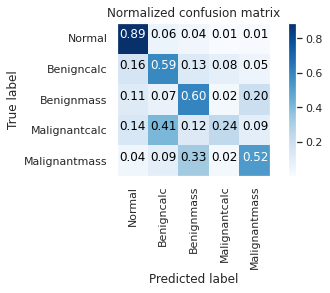

580/580 [==============================] - 18s 30ms/step - loss: 0.3614 - accuracy: 0.5341 - val_loss: 0.3422 - val_accuracy: 0.5899
Epoch 21/70
579/580 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.5403
Epoch 00021: val_accuracy did not improve from 0.58991
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.3271273217925904


---------------------
|      Accuracy      |
---------------------

    0.3427027027027027


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.30      0.98      0.46       200
           1       0.45      0.03      0.05       191
           2       0.37      0.22      0.28       210
           3       0.63      0.12      0.20       143
           4       0.49      0.28      0.36       181

    accuracy                           0.34

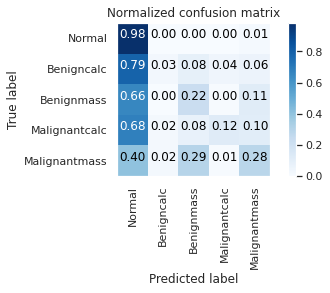

580/580 [==============================] - 17s 29ms/step - loss: 0.3576 - accuracy: 0.5404 - val_loss: 1.1917 - val_accuracy: 0.3432
Epoch 22/70
579/580 [============================>.] - ETA: 0s - loss: 0.3489 - accuracy: 0.5501
Epoch 00022: val_accuracy did not improve from 0.58991
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4492301498218307


---------------------
|      Accuracy      |
---------------------

    0.4627027027027027


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.43      0.97      0.59       200
           1       0.55      0.34      0.42       191
           2       0.44      0.21      0.29       210
           3       0.51      0.17      0.26       143
           4       0.49      0.55      0.52       181

    accuracy                           0.46

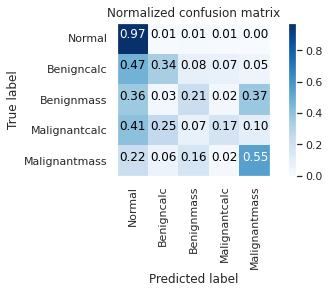

580/580 [==============================] - 17s 29ms/step - loss: 0.3491 - accuracy: 0.5501 - val_loss: 0.4297 - val_accuracy: 0.4616
Epoch 23/70
579/580 [============================>.] - ETA: 0s - loss: 0.3474 - accuracy: 0.5559
Epoch 00023: val_accuracy did not improve from 0.58991
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5272654583564016


---------------------
|      Accuracy      |
---------------------

    0.5178378378378379


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.84      0.72      0.78       200
           1       0.65      0.19      0.30       191
           2       0.58      0.30      0.40       210
           3       0.34      0.59      0.43       143
           4       0.44      0.82      0.58       181

    accuracy                           0.52

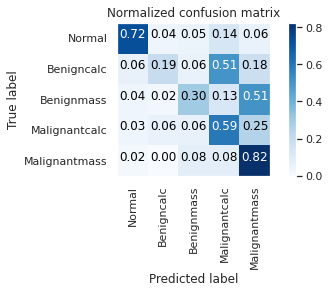

580/580 [==============================] - 17s 29ms/step - loss: 0.3473 - accuracy: 0.5560 - val_loss: 0.3971 - val_accuracy: 0.5208
Epoch 24/70
579/580 [============================>.] - ETA: 0s - loss: 0.3422 - accuracy: 0.5701
Epoch 00024: val_accuracy did not improve from 0.58991
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4976598754672573


---------------------
|      Accuracy      |
---------------------

    0.5070270270270271


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.48      0.95      0.63       200
           1       0.66      0.26      0.37       191
           2       0.49      0.47      0.48       210
           3       0.48      0.41      0.44       143
           4       0.58      0.39      0.47       181

    accuracy                           0.51

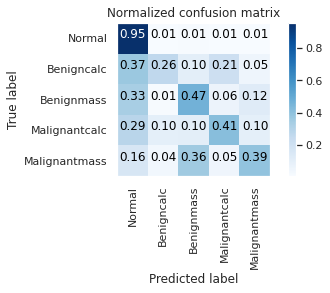

580/580 [==============================] - 17s 29ms/step - loss: 0.3421 - accuracy: 0.5699 - val_loss: 0.5359 - val_accuracy: 0.5077
Epoch 25/70
580/580 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.5686
Epoch 00025: val_accuracy improved from 0.58991 to 0.60197, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5896814873824796


---------------------
|      Accuracy      |
---------------------

    0.6021621621621621


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.68      0.94      0.79       200
           1       0.58      0.46      0.51       191
           2       0.57      0.59      0.58       210
           3       0.50      0.43      0.46       143
           

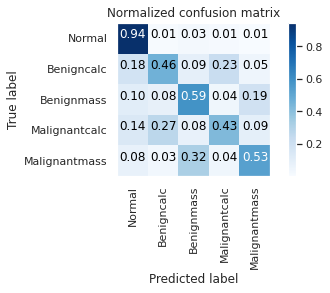

580/580 [==============================] - 18s 30ms/step - loss: 0.3417 - accuracy: 0.5686 - val_loss: 0.3250 - val_accuracy: 0.6020
Epoch 26/70
580/580 [==============================] - ETA: 0s - loss: 0.3345 - accuracy: 0.5875
Epoch 00026: val_accuracy did not improve from 0.60197
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5822632576028486


---------------------
|      Accuracy      |
---------------------

    0.5913513513513513


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       200
           1       0.62      0.43      0.51       191
           2       0.64      0.48      0.55       210
           3       0.38      0.41      0.39       143
           4       0.52      0.66      0.58       181

    accuracy                           0.59

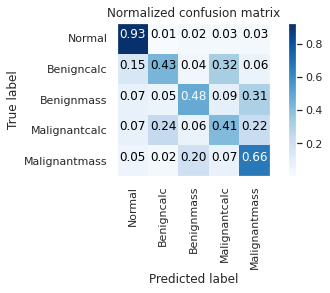

580/580 [==============================] - 17s 29ms/step - loss: 0.3345 - accuracy: 0.5875 - val_loss: 0.3165 - val_accuracy: 0.5921
Epoch 27/70
580/580 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.5918
Epoch 00027: val_accuracy improved from 0.60197 to 0.62719, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.6172830045582353


---------------------
|      Accuracy      |
---------------------

    0.6270270270270271


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       200
           1       0.56      0.57      0.57       191
           2       0.60      0.57      0.58       210
           3       0.43      0.44      0.44       143
           

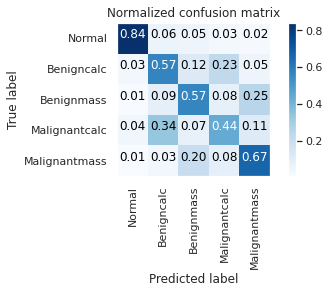

580/580 [==============================] - 18s 31ms/step - loss: 0.3313 - accuracy: 0.5918 - val_loss: 0.3096 - val_accuracy: 0.6272
Epoch 28/70
579/580 [============================>.] - ETA: 0s - loss: 0.3306 - accuracy: 0.5882
Epoch 00028: val_accuracy did not improve from 0.62719
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5959291346182382


---------------------
|      Accuracy      |
---------------------

    0.6118918918918919


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.66      0.94      0.78       200
           1       0.60      0.48      0.53       191
           2       0.57      0.59      0.58       210
           3       0.54      0.34      0.42       143
           4       0.63      0.63      0.63       181

    accuracy                           0.61

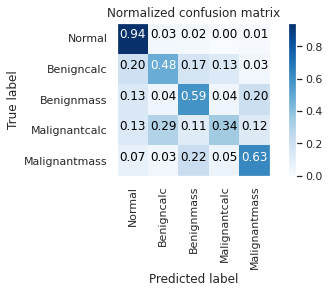

580/580 [==============================] - 17s 29ms/step - loss: 0.3305 - accuracy: 0.5883 - val_loss: 0.3319 - val_accuracy: 0.6107
Epoch 29/70
580/580 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.5987
Epoch 00029: val_accuracy did not improve from 0.62719
Predicting test data
58/58 [==============================] - 0s 8ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.544616857673003


---------------------
|      Accuracy      |
---------------------

    0.5675675675675675


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.53      0.98      0.69       200
           1       0.72      0.47      0.57       191
           2       0.52      0.67      0.59       210
           3       0.55      0.28      0.37       143
           4       0.69      0.33      0.44       181

    accuracy                           0.57 

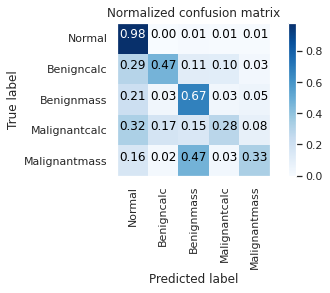

580/580 [==============================] - 17s 29ms/step - loss: 0.3237 - accuracy: 0.5987 - val_loss: 0.4072 - val_accuracy: 0.5658
Epoch 30/70
579/580 [============================>.] - ETA: 0s - loss: 0.3197 - accuracy: 0.6129
Epoch 00030: val_accuracy did not improve from 0.62719
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5556695469158227


---------------------
|      Accuracy      |
---------------------

    0.5783783783783784


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.55      0.97      0.71       200
           1       0.65      0.49      0.56       191
           2       0.49      0.64      0.55       210
           3       0.67      0.26      0.37       143
           4       0.76      0.41      0.54       181

    accuracy                           0.58

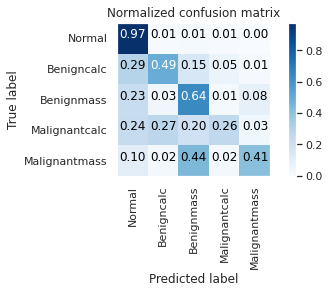

580/580 [==============================] - 17s 29ms/step - loss: 0.3200 - accuracy: 0.6125 - val_loss: 0.3419 - val_accuracy: 0.5779
Epoch 31/70
579/580 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.6143
Epoch 00031: val_accuracy did not improve from 0.62719
Predicting test data
58/58 [==============================] - 0s 8ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.4796037445242559


---------------------
|      Accuracy      |
---------------------

    0.4962162162162162


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.53      0.92      0.67       200
           1       0.69      0.18      0.28       191
           2       0.46      0.56      0.51       210
           3       0.45      0.27      0.34       143
           4       0.46      0.48      0.46       181

    accuracy                           0.50

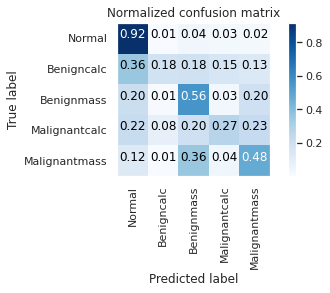

580/580 [==============================] - 17s 29ms/step - loss: 0.3156 - accuracy: 0.6144 - val_loss: 0.4231 - val_accuracy: 0.4956
Epoch 32/70
579/580 [============================>.] - ETA: 0s - loss: 0.3114 - accuracy: 0.6243
Epoch 00032: val_accuracy did not improve from 0.62719
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.6286974311159322


---------------------
|      Accuracy      |
---------------------

    0.6237837837837837


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       200
           1       0.68      0.44      0.53       191
           2       0.71      0.46      0.56       210
           3       0.39      0.68      0.50       143
           4       0.61      0.72      0.66       181

    accuracy                           0.62

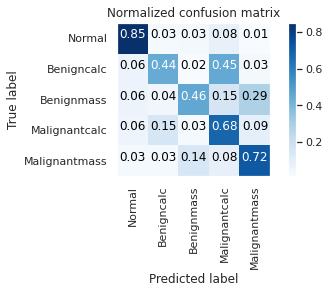

580/580 [==============================] - 17s 29ms/step - loss: 0.3113 - accuracy: 0.6242 - val_loss: 0.3108 - val_accuracy: 0.6250
Epoch 33/70
580/580 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.6318
Epoch 00033: val_accuracy did not improve from 0.62719
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5939792211009416


---------------------
|      Accuracy      |
---------------------

    0.6


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       200
           1       0.70      0.45      0.54       191
           2       0.57      0.47      0.51       210
           3       0.47      0.43      0.45       143
           4       0.46      0.81      0.59       181

    accuracy                           0.60       925
   m

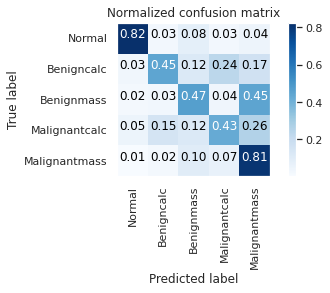

580/580 [==============================] - 17s 29ms/step - loss: 0.3076 - accuracy: 0.6318 - val_loss: 0.3272 - val_accuracy: 0.6009
Epoch 34/70
579/580 [============================>.] - ETA: 0s - loss: 0.2996 - accuracy: 0.6423
Epoch 00034: val_accuracy improved from 0.62719 to 0.64364, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.632587180852085


---------------------
|      Accuracy      |
---------------------

    0.6421621621621622


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.61      0.97      0.75       200
           1       0.74      0.59      0.66       191
           2       0.62      0.56      0.59       210
           3       0.60      0.50      0.55       143
           4

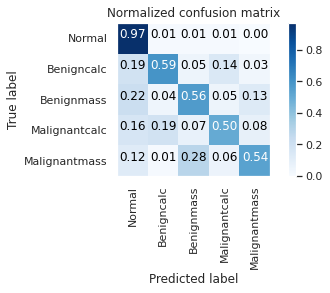

580/580 [==============================] - 18s 30ms/step - loss: 0.2995 - accuracy: 0.6424 - val_loss: 0.3448 - val_accuracy: 0.6436
Epoch 35/70
580/580 [==============================] - ETA: 0s - loss: 0.2970 - accuracy: 0.6471
Epoch 00035: val_accuracy did not improve from 0.64364
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.6387056709645584


---------------------
|      Accuracy      |
---------------------

    0.6356756756756756


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       200
           1       0.70      0.50      0.58       191
           2       0.58      0.56      0.57       210
           3       0.48      0.69      0.57       143
           4       0.59      0.65      0.62       181

    accuracy                           0.64

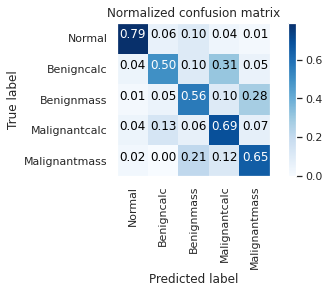

580/580 [==============================] - 17s 29ms/step - loss: 0.2970 - accuracy: 0.6471 - val_loss: 0.2961 - val_accuracy: 0.6349
Epoch 36/70
580/580 [==============================] - ETA: 0s - loss: 0.2938 - accuracy: 0.6506
Epoch 00036: val_accuracy did not improve from 0.64364
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.6461510613228527


---------------------
|      Accuracy      |
---------------------

    0.6378378378378379


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       200
           1       0.82      0.34      0.48       191
           2       0.66      0.52      0.58       210
           3       0.43      0.79      0.55       143
           4       0.61      0.70      0.65       181

    accuracy                           0.64

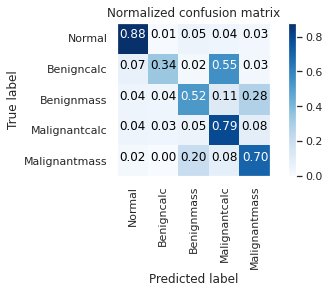

580/580 [==============================] - 17s 29ms/step - loss: 0.2938 - accuracy: 0.6506 - val_loss: 0.2935 - val_accuracy: 0.6393
Epoch 37/70
578/580 [============================>.] - ETA: 0s - loss: 0.2859 - accuracy: 0.6655
Epoch 00037: val_accuracy did not improve from 0.64364
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.5905492413634787


---------------------
|      Accuracy      |
---------------------

    0.6075675675675676


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.55      0.95      0.70       200
           1       0.79      0.34      0.48       191
           2       0.64      0.63      0.63       210
           3       0.62      0.32      0.42       143
           4       0.60      0.71      0.65       181

    accuracy                           0.61

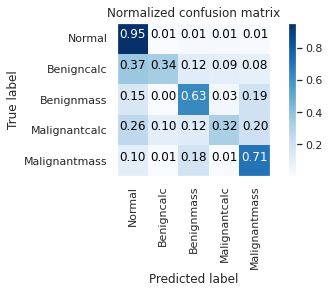

580/580 [==============================] - 17s 29ms/step - loss: 0.2859 - accuracy: 0.6656 - val_loss: 0.4044 - val_accuracy: 0.6086
Epoch 38/70
580/580 [==============================] - ETA: 0s - loss: 0.2805 - accuracy: 0.6700
Epoch 00038: val_accuracy improved from 0.64364 to 0.71272, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.6975674847459292


---------------------
|      Accuracy      |
---------------------

    0.7145945945945946


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       200
           1       0.70      0.73      0.71       191
           2       0.65      0.73      0.69       210
           3       0.68      0.45      0.54       143
           

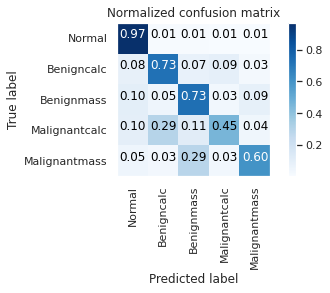

580/580 [==============================] - 18s 31ms/step - loss: 0.2805 - accuracy: 0.6700 - val_loss: 0.2512 - val_accuracy: 0.7127
Epoch 39/70
580/580 [==============================] - ETA: 0s - loss: 0.2761 - accuracy: 0.6810
Epoch 00039: val_accuracy did not improve from 0.71272
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.6904442770404414


---------------------
|      Accuracy      |
---------------------

    0.6897297297297297


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       200
           1       0.65      0.66      0.66       191
           2       0.73      0.65      0.69       210
           3       0.46      0.78      0.58       143
           4       0.86      0.44      0.58       181

    accuracy                           0.69

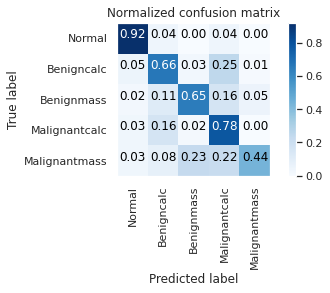

580/580 [==============================] - 17s 29ms/step - loss: 0.2761 - accuracy: 0.6810 - val_loss: 0.2658 - val_accuracy: 0.6897
Epoch 40/70
579/580 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.6956
Epoch 00040: val_accuracy did not improve from 0.71272
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.47585203268764636


---------------------
|      Accuracy      |
---------------------

    0.49405405405405406


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.42      0.98      0.59       200
           1       0.64      0.32      0.43       191
           2       0.49      0.50      0.50       210
           3       0.54      0.27      0.36       143
           4       0.73      0.31      0.43       181

    accuracy                           0.

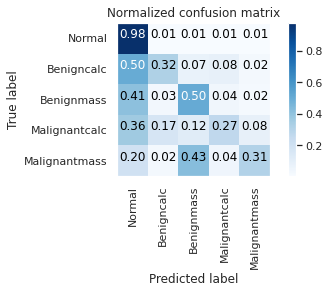

580/580 [==============================] - 17s 29ms/step - loss: 0.2651 - accuracy: 0.6958 - val_loss: 0.6009 - val_accuracy: 0.4934
Epoch 41/70
579/580 [============================>.] - ETA: 0s - loss: 0.2652 - accuracy: 0.6987
Epoch 00041: val_accuracy did not improve from 0.71272
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.6796028125933826


---------------------
|      Accuracy      |
---------------------

    0.68


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       200
           1       0.85      0.49      0.62       191
           2       0.64      0.57      0.60       210
           3       0.55      0.63      0.59       143
           4       0.55      0.85      0.67       181

    accuracy                           0.68       925
   

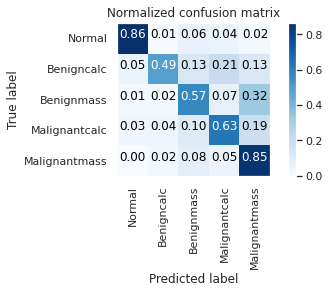

580/580 [==============================] - 17s 29ms/step - loss: 0.2654 - accuracy: 0.6985 - val_loss: 0.2670 - val_accuracy: 0.6798
Epoch 42/70
580/580 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.7129
Epoch 00042: val_accuracy improved from 0.71272 to 0.73465, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 8ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.7289917665279964


---------------------
|      Accuracy      |
---------------------

    0.7329729729729729


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       200
           1       0.79      0.65      0.71       191
           2       0.68      0.64      0.66       210
           3       0.67      0.64      0.66       143
           

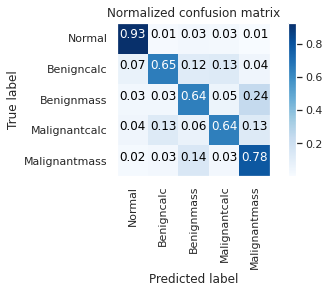

580/580 [==============================] - 17s 30ms/step - loss: 0.2556 - accuracy: 0.7129 - val_loss: 0.2391 - val_accuracy: 0.7346
Epoch 43/70
580/580 [==============================] - ETA: 0s - loss: 0.2481 - accuracy: 0.7225
Epoch 00043: val_accuracy did not improve from 0.73465
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.673528811329251


---------------------
|      Accuracy      |
---------------------

    0.68


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.62      0.95      0.75       200
           1       0.79      0.46      0.58       191
           2       0.71      0.63      0.67       210
           3       0.65      0.57      0.60       143
           4       0.71      0.76      0.73       181

    accuracy                           0.68       925
   m

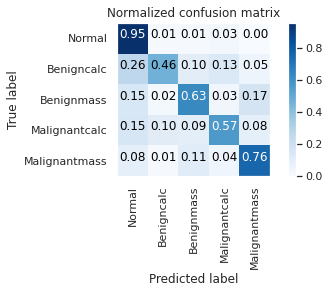

580/580 [==============================] - 17s 29ms/step - loss: 0.2481 - accuracy: 0.7225 - val_loss: 0.3074 - val_accuracy: 0.6809
Epoch 44/70
579/580 [============================>.] - ETA: 0s - loss: 0.2427 - accuracy: 0.7241
Epoch 00044: val_accuracy improved from 0.73465 to 0.78289, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.7867383415616327


---------------------
|      Accuracy      |
---------------------

    0.7827027027027027


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       200
           1       0.84      0.72      0.78       191
           2       0.87      0.65      0.74       210
           3       0.59      0.83      0.69       143
           

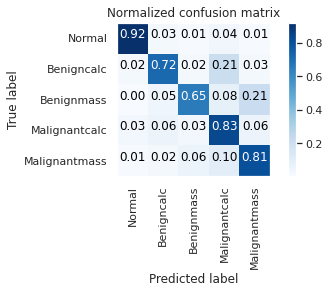

580/580 [==============================] - 18s 30ms/step - loss: 0.2428 - accuracy: 0.7240 - val_loss: 0.2041 - val_accuracy: 0.7829
Epoch 45/70
579/580 [============================>.] - ETA: 0s - loss: 0.2383 - accuracy: 0.7379
Epoch 00045: val_accuracy did not improve from 0.78289
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.7732371497737557


---------------------
|      Accuracy      |
---------------------

    0.7783783783783784


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       200
           1       0.83      0.78      0.81       191
           2       0.73      0.68      0.71       210
           3       0.76      0.65      0.70       143
           4       0.66      0.84      0.74       181

    accuracy                           0.78

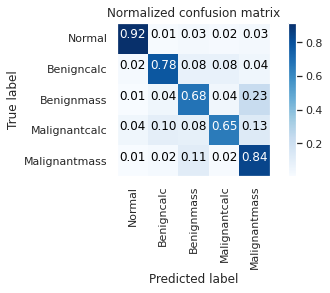

580/580 [==============================] - 17s 29ms/step - loss: 0.2382 - accuracy: 0.7381 - val_loss: 0.2085 - val_accuracy: 0.7796
Epoch 46/70
579/580 [============================>.] - ETA: 0s - loss: 0.2281 - accuracy: 0.7491
Epoch 00046: val_accuracy did not improve from 0.78289
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.7090673118498751


---------------------
|      Accuracy      |
---------------------

    0.7081081081081081


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.71      0.92      0.80       200
           1       0.80      0.62      0.70       191
           2       0.79      0.56      0.65       210
           3       0.62      0.70      0.66       143
           4       0.65      0.75      0.70       181

    accuracy                           0.71

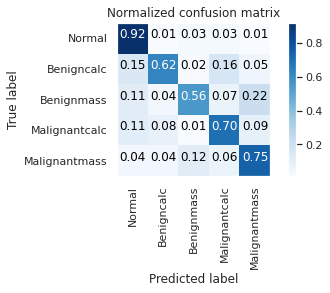

580/580 [==============================] - 17s 29ms/step - loss: 0.2282 - accuracy: 0.7488 - val_loss: 0.2995 - val_accuracy: 0.7105
Epoch 47/70
579/580 [============================>.] - ETA: 0s - loss: 0.2212 - accuracy: 0.7585
Epoch 00047: val_accuracy improved from 0.78289 to 0.79934, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.7866439382934421


---------------------
|      Accuracy      |
---------------------

    0.8


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       200
           1       0.85      0.77      0.81       191
           2       0.70      0.85      0.77       210
           3       0.87      0.60      0.71       143
           4       0.83   

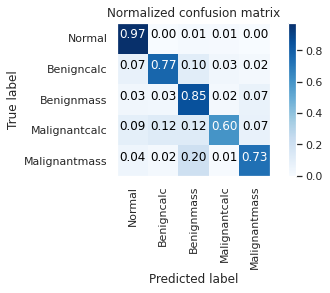

580/580 [==============================] - 18s 30ms/step - loss: 0.2214 - accuracy: 0.7582 - val_loss: 0.1862 - val_accuracy: 0.7993
Epoch 48/70
580/580 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.7624
Epoch 00048: val_accuracy did not improve from 0.79934
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.739785547525474


---------------------
|      Accuracy      |
---------------------

    0.7524324324324324


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.75      0.96      0.84       200
           1       0.85      0.63      0.72       191
           2       0.65      0.86      0.74       210
           3       0.81      0.61      0.70       143
           4       0.81      0.64      0.71       181

    accuracy                           0.75 

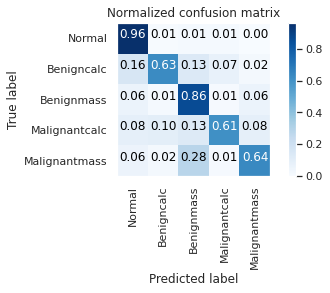

580/580 [==============================] - 17s 29ms/step - loss: 0.2157 - accuracy: 0.7624 - val_loss: 0.2177 - val_accuracy: 0.7511
Epoch 49/70
580/580 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.7730
Epoch 00049: val_accuracy did not improve from 0.79934
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.7556229864742491


---------------------
|      Accuracy      |
---------------------

    0.7643243243243243


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.79      0.95      0.87       200
           1       0.87      0.61      0.72       191
           2       0.70      0.80      0.75       210
           3       0.76      0.64      0.70       143
           4       0.75      0.76      0.75       181

    accuracy                           0.76

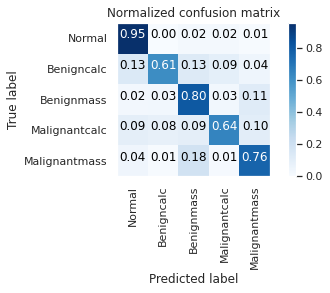

580/580 [==============================] - 17s 29ms/step - loss: 0.2080 - accuracy: 0.7730 - val_loss: 0.2166 - val_accuracy: 0.7664
Epoch 50/70
579/580 [============================>.] - ETA: 0s - loss: 0.2043 - accuracy: 0.7758
Epoch 00050: val_accuracy improved from 0.79934 to 0.87390, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.8728336265279367


---------------------
|      Accuracy      |
---------------------

    0.8756756756756757


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       200
           1       0.92      0.83      0.87       191
           2       0.83      0.87      0.85       210
           3       0.86      0.84      0.85       143
           

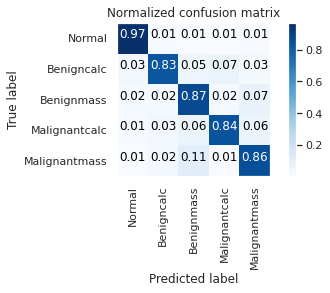

580/580 [==============================] - 18s 30ms/step - loss: 0.2044 - accuracy: 0.7759 - val_loss: 0.1382 - val_accuracy: 0.8739
Epoch 51/70
580/580 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.7970
Epoch 00051: val_accuracy did not improve from 0.87390
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.702950194310236


---------------------
|      Accuracy      |
---------------------

    0.7113513513513513


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.61      0.96      0.75       200
           1       0.81      0.71      0.76       191
           2       0.63      0.70      0.67       210
           3       0.83      0.63      0.72       143
           4       0.91      0.51      0.66       181

    accuracy                           0.71 

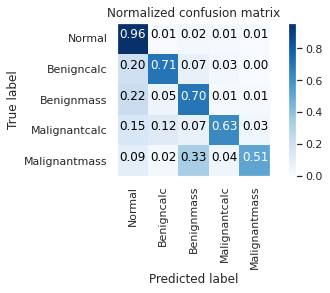

580/580 [==============================] - 17s 29ms/step - loss: 0.1922 - accuracy: 0.7970 - val_loss: 0.3274 - val_accuracy: 0.7105
Epoch 52/70
579/580 [============================>.] - ETA: 0s - loss: 0.1906 - accuracy: 0.7972
Epoch 00052: val_accuracy did not improve from 0.87390
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.8377938910375635


---------------------
|      Accuracy      |
---------------------

    0.8313513513513513


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       200
           1       0.85      0.82      0.83       191
           2       0.90      0.72      0.80       210
           3       0.64      0.94      0.76       143
           4       0.85      0.80      0.82       181

    accuracy                           0.83

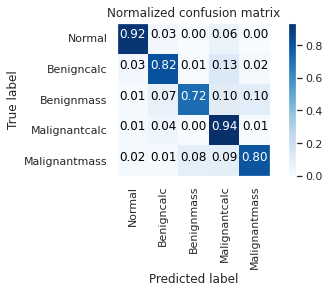

580/580 [==============================] - 17s 29ms/step - loss: 0.1907 - accuracy: 0.7969 - val_loss: 0.1600 - val_accuracy: 0.8322
Epoch 53/70
579/580 [============================>.] - ETA: 0s - loss: 0.1827 - accuracy: 0.8036
Epoch 00053: val_accuracy did not improve from 0.87390
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.774697723169101


---------------------
|      Accuracy      |
---------------------

    0.7848648648648648


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.77      0.98      0.87       200
           1       0.87      0.69      0.77       191
           2       0.70      0.88      0.78       210
           3       0.80      0.69      0.74       143
           4       0.87      0.64      0.74       181

    accuracy                           0.78 

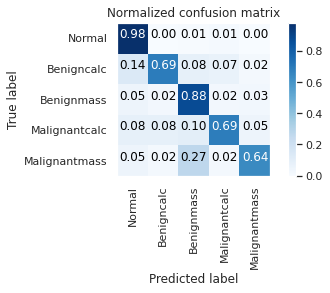

580/580 [==============================] - 17s 29ms/step - loss: 0.1827 - accuracy: 0.8036 - val_loss: 0.1957 - val_accuracy: 0.7851
Epoch 54/70
579/580 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.8157
Epoch 00054: val_accuracy did not improve from 0.87390
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.7577688271636956


---------------------
|      Accuracy      |
---------------------

    0.7643243243243243


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       200
           1       0.84      0.68      0.75       191
           2       0.69      0.73      0.71       210
           3       0.73      0.65      0.69       143
           4       0.73      0.78      0.76       181

    accuracy                           0.76

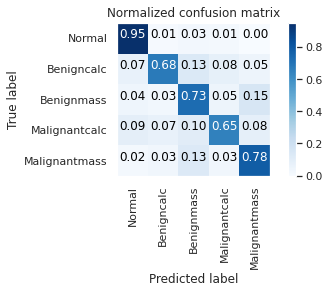

580/580 [==============================] - 17s 29ms/step - loss: 0.1734 - accuracy: 0.8156 - val_loss: 0.2141 - val_accuracy: 0.7664
Epoch 55/70
579/580 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.8242
Epoch 00055: val_accuracy improved from 0.87390 to 0.90351, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.9019144721139456


---------------------
|      Accuracy      |
---------------------

    0.9037837837837838


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       200
           1       0.93      0.82      0.87       191
           2       0.89      0.92      0.90       210
           3       0.83      0.88      0.86       143
           

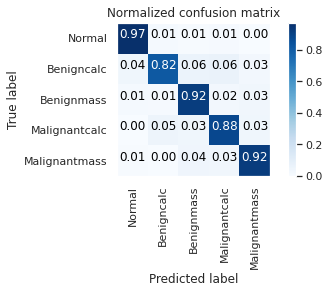

580/580 [==============================] - 18s 30ms/step - loss: 0.1679 - accuracy: 0.8240 - val_loss: 0.1119 - val_accuracy: 0.9035
Epoch 56/70
579/580 [============================>.] - ETA: 0s - loss: 0.1598 - accuracy: 0.8315
Epoch 00056: val_accuracy did not improve from 0.90351
Predicting test data
58/58 [==============================] - 0s 8ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.8827041993036323


---------------------
|      Accuracy      |
---------------------

    0.8864864864864865


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       200
           1       0.92      0.88      0.90       191
           2       0.83      0.90      0.86       210
           3       0.86      0.84      0.85       143
           4       0.91      0.84      0.87       181

    accuracy                           0.89

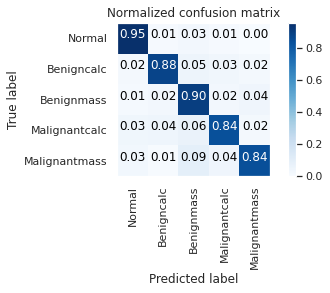

580/580 [==============================] - 17s 29ms/step - loss: 0.1599 - accuracy: 0.8314 - val_loss: 0.1128 - val_accuracy: 0.8882
Epoch 57/70
580/580 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.8357
Epoch 00057: val_accuracy did not improve from 0.90351
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.8927000041216872


---------------------
|      Accuracy      |
---------------------

    0.8918918918918919


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       200
           1       0.86      0.93      0.89       191
           2       0.90      0.85      0.88       210
           3       0.79      0.92      0.85       143
           4       0.95      0.80      0.87       181

    accuracy                           0.89

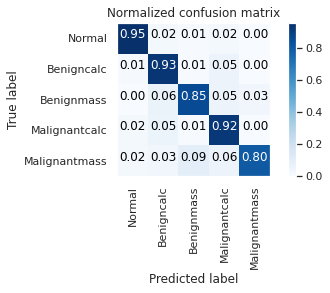

580/580 [==============================] - 17s 29ms/step - loss: 0.1578 - accuracy: 0.8357 - val_loss: 0.1138 - val_accuracy: 0.8904
Epoch 58/70
580/580 [==============================] - ETA: 0s - loss: 0.1523 - accuracy: 0.8374
Epoch 00058: val_accuracy did not improve from 0.90351
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.8626683845788875


---------------------
|      Accuracy      |
---------------------

    0.867027027027027


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       200
           1       0.90      0.85      0.87       191
           2       0.85      0.86      0.85       210
           3       0.95      0.80      0.87       143
           4       0.89      0.85      0.87       181

    accuracy                           0.87 

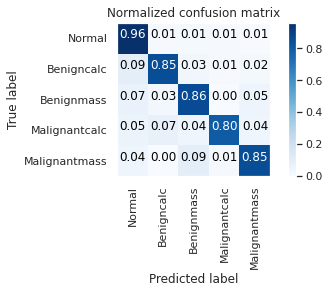

580/580 [==============================] - 17s 29ms/step - loss: 0.1523 - accuracy: 0.8374 - val_loss: 0.1329 - val_accuracy: 0.8662
Epoch 59/70
580/580 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.8531
Epoch 00059: val_accuracy did not improve from 0.90351
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.877454631625642


---------------------
|      Accuracy      |
---------------------

    0.88


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       200
           1       0.92      0.83      0.87       191
           2       0.86      0.90      0.88       210
           3       0.92      0.87      0.89       143
           4       0.95      0.82      0.88       181

    accuracy                           0.88       925
   m

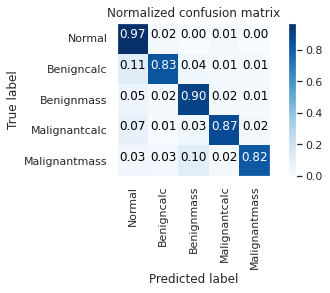

580/580 [==============================] - 17s 29ms/step - loss: 0.1429 - accuracy: 0.8531 - val_loss: 0.1227 - val_accuracy: 0.8794
Epoch 60/70
579/580 [============================>.] - ETA: 0s - loss: 0.1402 - accuracy: 0.8559
Epoch 00060: val_accuracy did not improve from 0.90351
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.8670751931916781


---------------------
|      Accuracy      |
---------------------

    0.865945945945946


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       200
           1       0.86      0.85      0.86       191
           2       0.92      0.80      0.85       210
           3       0.84      0.90      0.86       143
           4       0.94      0.81      0.87       181

    accuracy                           0.87 

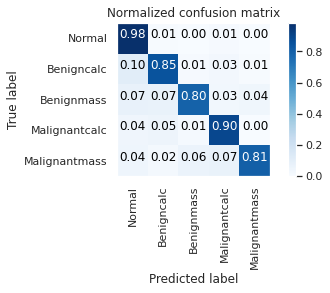

580/580 [==============================] - 17s 29ms/step - loss: 0.1402 - accuracy: 0.8560 - val_loss: 0.1199 - val_accuracy: 0.8662
Epoch 61/70
580/580 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.8602
Epoch 00061: val_accuracy did not improve from 0.90351
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.881227640823111


---------------------
|      Accuracy      |
---------------------

    0.8864864864864865


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       200
           1       0.95      0.88      0.92       191
           2       0.89      0.88      0.88       210
           3       0.98      0.80      0.88       143
           4       0.89      0.87      0.88       181

    accuracy                           0.89 

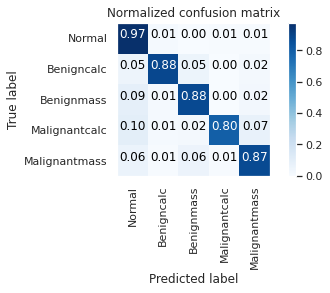

580/580 [==============================] - 17s 29ms/step - loss: 0.1365 - accuracy: 0.8602 - val_loss: 0.1268 - val_accuracy: 0.8860
Epoch 62/70
579/580 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.8624
Epoch 00062: val_accuracy improved from 0.90351 to 0.92873, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.9278285442826532


---------------------
|      Accuracy      |
---------------------

    0.9297297297297298


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.99      0.91      0.95       191
           2       0.87      0.96      0.91       210
           3       0.93      0.92      0.93       143
           

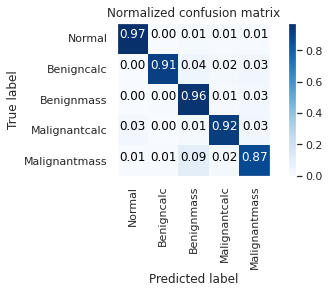

580/580 [==============================] - 18s 30ms/step - loss: 0.1323 - accuracy: 0.8625 - val_loss: 0.0728 - val_accuracy: 0.9287
Epoch 63/70
579/580 [============================>.] - ETA: 0s - loss: 0.1288 - accuracy: 0.8679
Epoch 00063: val_accuracy did not improve from 0.92873
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.8780031977702858


---------------------
|      Accuracy      |
---------------------

    0.8767567567567568


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       200
           1       0.97      0.77      0.86       191
           2       0.91      0.83      0.87       210
           3       0.78      0.89      0.83       143
           4       0.80      0.93      0.86       181

    accuracy                           0.88

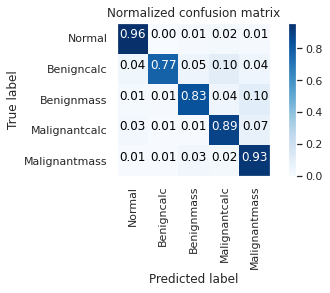

580/580 [==============================] - 17s 29ms/step - loss: 0.1289 - accuracy: 0.8678 - val_loss: 0.1210 - val_accuracy: 0.8783
Epoch 64/70
580/580 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.8732
Epoch 00064: val_accuracy did not improve from 0.92873
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.7591345140160621


---------------------
|      Accuracy      |
---------------------

    0.7632432432432432


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       200
           1       0.86      0.77      0.81       191
           2       0.69      0.74      0.71       210
           3       0.77      0.74      0.76       143
           4       0.75      0.60      0.66       181

    accuracy                           0.76

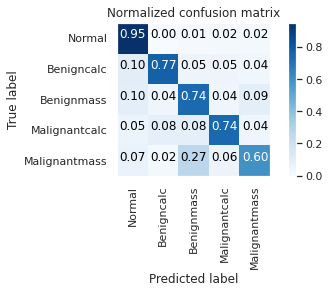

580/580 [==============================] - 17s 29ms/step - loss: 0.1232 - accuracy: 0.8732 - val_loss: 0.2420 - val_accuracy: 0.7621
Epoch 65/70
580/580 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.8775
Epoch 00065: val_accuracy did not improve from 0.92873
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.9154815305316013


---------------------
|      Accuracy      |
---------------------

    0.9135135135135135


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       200
           1       0.92      0.89      0.90       191
           2       0.90      0.91      0.91       210
           3       0.83      0.96      0.89       143
           4       0.95      0.90      0.92       181

    accuracy                           0.91

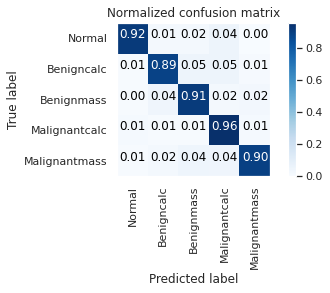

580/580 [==============================] - 17s 29ms/step - loss: 0.1204 - accuracy: 0.8775 - val_loss: 0.0889 - val_accuracy: 0.9145
Epoch 66/70
579/580 [============================>.] - ETA: 0s - loss: 0.1142 - accuracy: 0.8837
Epoch 00066: val_accuracy did not improve from 0.92873
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.6544272249786988


---------------------
|      Accuracy      |
---------------------

    0.6627027027027027


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.52      0.97      0.68       200
           1       0.89      0.57      0.70       191
           2       0.61      0.70      0.65       210
           3       0.82      0.62      0.71       143
           4       0.90      0.41      0.56       181

    accuracy                           0.66

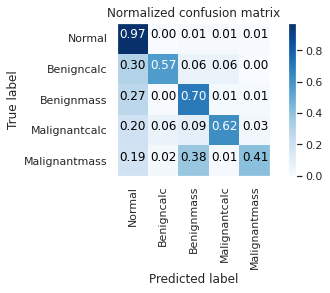

580/580 [==============================] - 17s 29ms/step - loss: 0.1144 - accuracy: 0.8835 - val_loss: 0.4514 - val_accuracy: 0.6601
Epoch 67/70
580/580 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.8842
Epoch 00067: val_accuracy did not improve from 0.92873
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.9069732102190521


---------------------
|      Accuracy      |
---------------------

    0.9059459459459459


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       200
           1       0.95      0.88      0.92       191
           2       0.89      0.94      0.91       210
           3       0.79      0.97      0.87       143
           4       0.97      0.81      0.89       181

    accuracy                           0.91

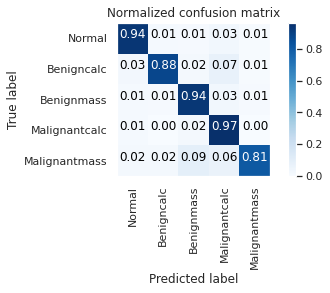

580/580 [==============================] - 17s 29ms/step - loss: 0.1136 - accuracy: 0.8842 - val_loss: 0.1005 - val_accuracy: 0.9057
Epoch 68/70
579/580 [============================>.] - ETA: 0s - loss: 0.1065 - accuracy: 0.8940
Epoch 00068: val_accuracy did not improve from 0.92873
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.9050433003499159


---------------------
|      Accuracy      |
---------------------

    0.9048648648648648


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       200
           1       0.93      0.88      0.91       191
           2       0.88      0.91      0.89       210
           3       0.85      0.92      0.88       143
           4       0.92      0.90      0.91       181

    accuracy                           0.90

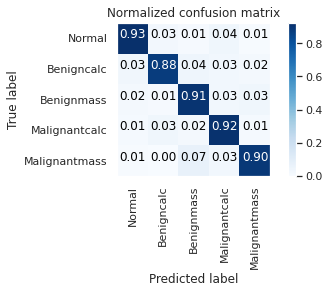

580/580 [==============================] - 17s 29ms/step - loss: 0.1067 - accuracy: 0.8938 - val_loss: 0.0930 - val_accuracy: 0.9046
Epoch 69/70
579/580 [============================>.] - ETA: 0s - loss: 0.1040 - accuracy: 0.8937
Epoch 00069: val_accuracy did not improve from 0.92873
Predicting test data
58/58 [==============================] - 0s 8ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.8679626857479104


---------------------
|      Accuracy      |
---------------------

    0.8724324324324324


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.77      0.98      0.86       200
           1       0.94      0.78      0.85       191
           2       0.88      0.87      0.88       210
           3       0.91      0.80      0.85       143
           4       0.92      0.91      0.91       181

    accuracy                           0.87

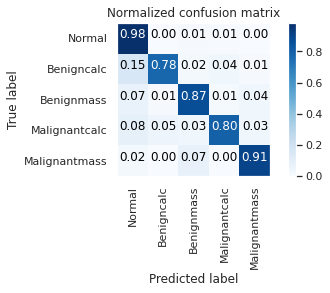

580/580 [==============================] - 17s 29ms/step - loss: 0.1039 - accuracy: 0.8939 - val_loss: 0.1691 - val_accuracy: 0.8739
Epoch 70/70
579/580 [============================>.] - ETA: 0s - loss: 0.1022 - accuracy: 0.9014
Epoch 00070: val_accuracy improved from 0.92873 to 0.92982, saving model to /content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5
Predicting test data
58/58 [==============================] - 0s 7ms/step
Done 
 

---------------------
| Balanced Accuracy  |
---------------------

    0.930488810159112


---------------------
|      Accuracy      |
---------------------

    0.9308108108108109


-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       200
           1       0.96      0.93      0.94       191
           2       0.95      0.92      0.93       210
           3       0.89      0.94      0.92       143
           4

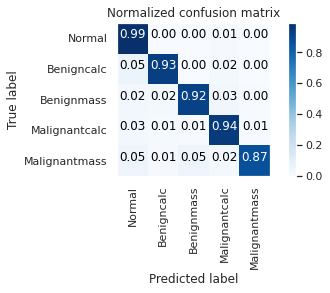

580/580 [==============================] - 17s 30ms/step - loss: 0.1022 - accuracy: 0.9014 - val_loss: 0.0680 - val_accuracy: 0.9298


In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = len(train_data) // 16,
                              validation_data=val_generator,
                              validation_steps= len(test_data)// 16,
                              epochs = 70,
                              callbacks = get_callbacks(),
                              class_weight = class_weights,
                              verbose = 1
                              )

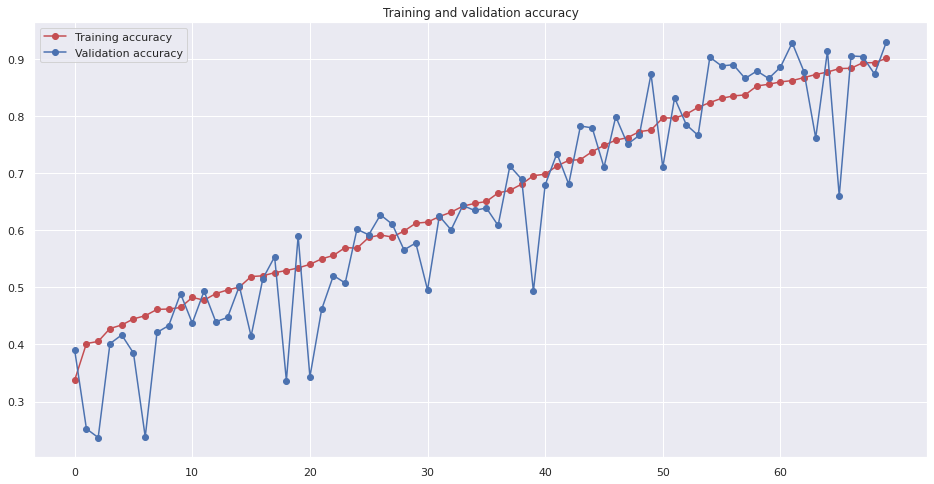

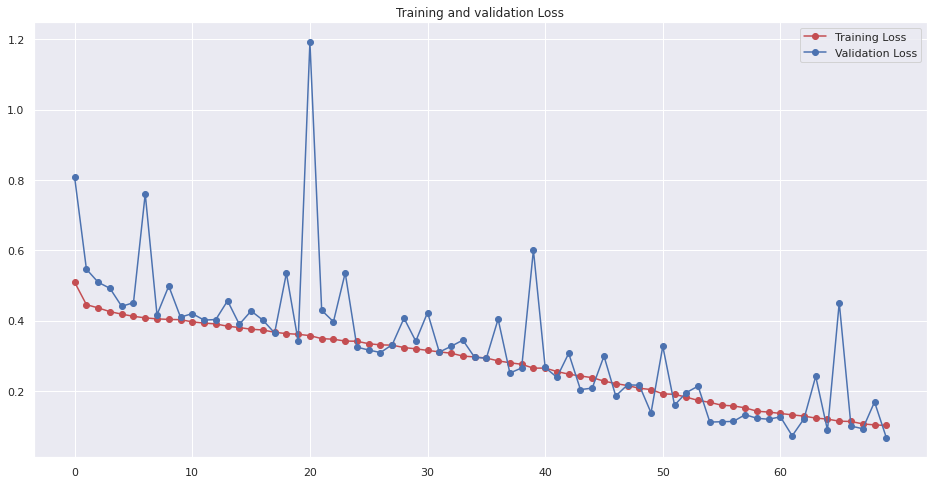

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = range(0,len(acc))
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.plot(epochs, acc, 'r', label='Training accuracy',marker = "o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',marker = "o")
plt.title('Training and validation accuracy')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
plt.figure()

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Training and validation Loss')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

In [ ]:


from keras.models import load_model
model = load_model('/content/gdrive/My Drive/ddsm_resnet50_s10_[512-512-1024]x2.h5')
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 prt_input_1
1 prt_zero_padding2d_1
2 prt_conv1
3 prt_bn_conv1
4 prt_activation_1
5 prt_max_pooling2d_1
6 prt_res2a_branch2a
7 prt_bn2a_branch2a
8 prt_activation_2
9 prt_res2a_branch2b
10 prt_bn2a_branch2b
11 prt_activation_3
12 prt_res2a_branch2c
13 prt_res2a_branch1
14 prt_bn2a_branch2c
15 prt_bn2a_branch1
16 prt_add_1
17 prt_activation_4
18 prt_res2b_branch2a
19 prt_bn2b_branch2a
20 prt_activation_5
21 prt_res2b_branch2b
22 prt_bn2b_branch2b
23 prt_activation_6
24 prt_res2b_branch2c
25 prt_bn2b_branch2c
26 prt_add_2
27 prt_activation_7
28 prt_res2c_branch2a
29 prt_bn2c_branch2a
30 prt_activation_8
31 prt_res2c_branch2b
32 prt_bn2c_branch2b
33 prt_activation_9
34 prt_res2c_branch2c
35 prt_bn2c_branch2c
36 prt_add_3
37 prt_activation_10
38 prt_res3a_branch2a
39 prt_bn3a_branch2a
40 prt_activation_11
41 prt_res3a_branch2b
42 prt_bn3a_branch2b
43 prt_activation_12
44 prt_res3a_branch2c
45 prt_res3a_branch1
46 prt_bn3a_branch2c
47 prt_bn3a_branch1
48 prt_add_4
49 prt_activation_13
50 pr

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

from keras.models import load_model
import cv2 as cv

def improve_contrast_image_using_clahe(bgr_image: np.array) -> np.array:
    hsv = cv.cvtColor(bgr_image, cv.COLOR_BGR2HSV)
    hsv_planes = cv.split(hsv)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    hsv_planes[2] = clahe.apply(hsv_planes[2])
    hsv = cv.merge(hsv_planes)
    return cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

# load model
model = load_model('/content/gdrive/My Drive/ddsm_resnet50_s10_[512-512-1024]x2.h5')
# summarize model.
#model.summary()

#model = base_model.load_weights('/content/weights-improvement-02-0.84.hdf5')
#model = tf.keras.applications.InceptionV3(weights='/content/weights-improvement-04-0.85.hdf5')
model = Model(inputs=model.input, outputs= model.get_layer('dense_1').output)
#model = base_model.load_weights('/content/weights-improvement-04-0.85.hdf5')
img_path = '/content/gdrive/My Drive/mdb001.pgm'
img = image.load_img(img_path, target_size=(224, 224))
img = improve_contrast_image_using_clahe(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

pred = model.predict(x)

print(pred)


TypeError: ignored

(1, 4, 4)


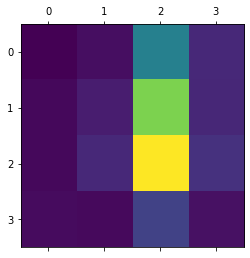

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow 

conv_layer = model.get_layer('conv2d_1')
heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_1')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

print(heatmap.shape)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((4, 4))
plt.matshow(heatmap)
plt.show()

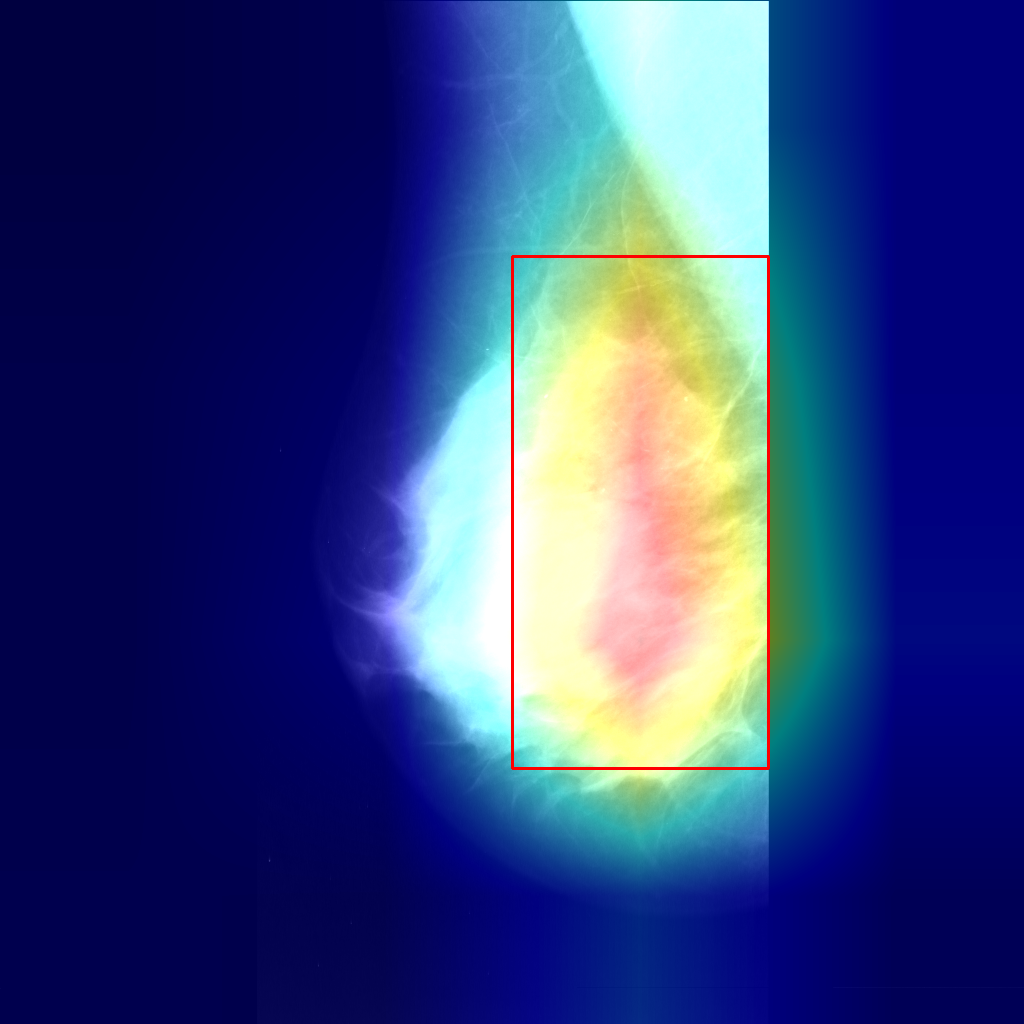

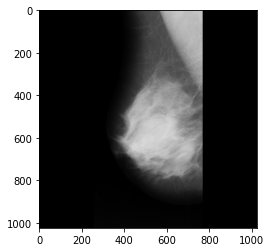

In [ ]:
img = cv2.imread('/content/gdrive/My Drive/mdb001.pgm')
INTENSITY = 0.5
plt.imshow(img)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

imgmapped = heatmap * INTENSITY + img
# cv2.rectangle(img, (535,425),(732,622), (255,0,0), 2)
# cv2_imshow(img)
cv2.rectangle(imgmapped, (512,256),(768,768), (0,0,255), 2)
cv2_imshow(imgmapped)

[[0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0.]]


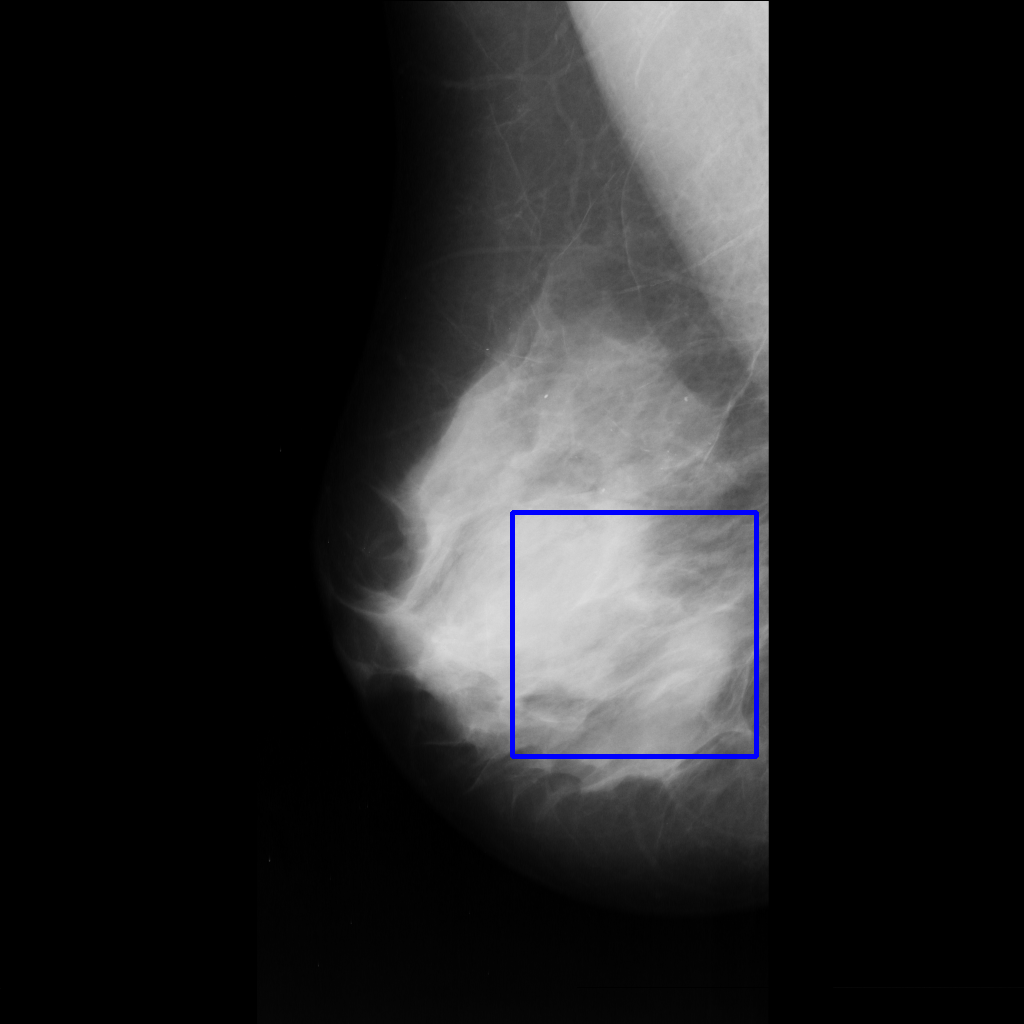

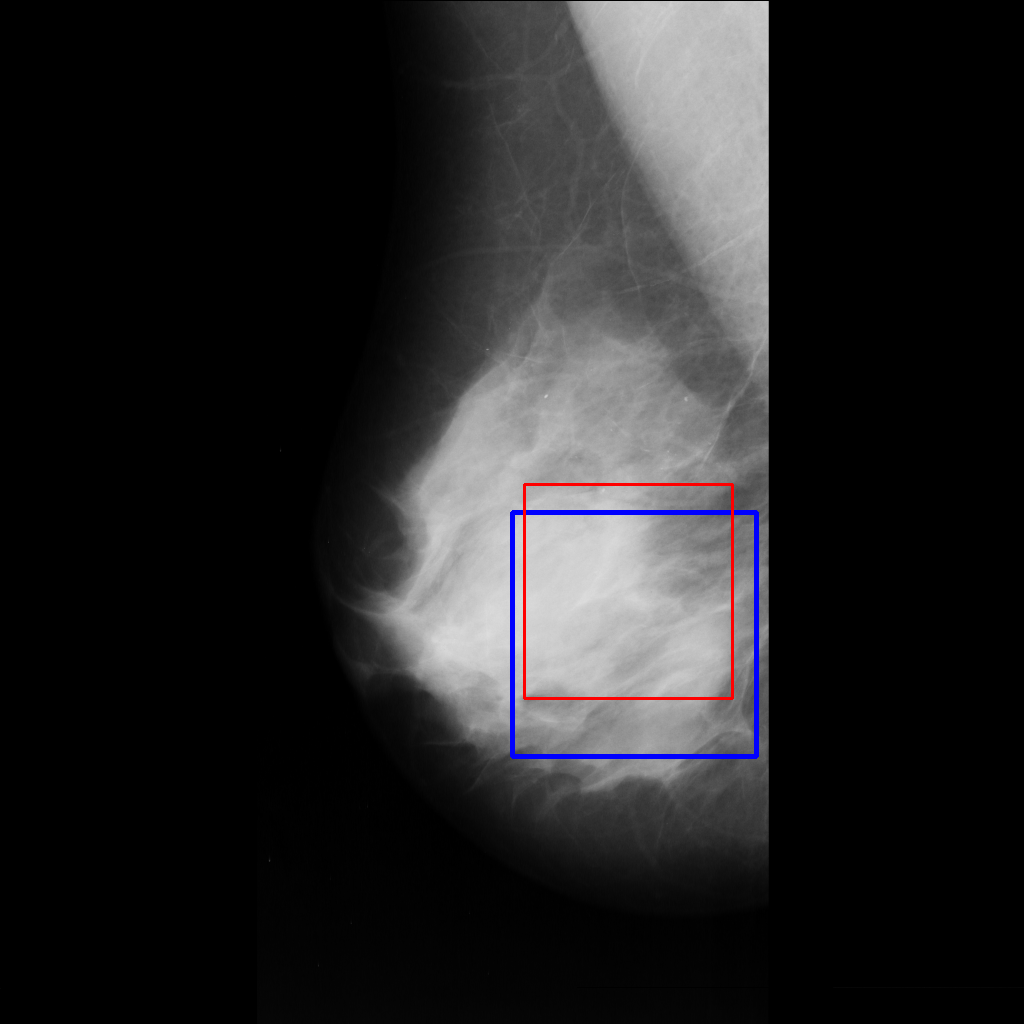

In [ ]:
cropped_img1 = img[512:768,256:512,:]
cropped_img2 = img[512:768,512:768,:]



from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np

from keras.models import load_model
 
# load model
model = load_model('/content/gdrive/My Drive/CBIS_DDSM_IMAGES/model_multiclass_128.h5')

model = Model(inputs=model.input, outputs= model.get_layer('activation_15').output)
#model = base_model.load_weights('/content/weights-improvement-04-0.85.hdf5')

# x = image.img_to_array(cropped_img1)
# x = np.expand_dims(x, axis=0)
# # x = preprocess_input(x)
x1 = np.resize(cropped_img1,(1,128,128,3))
pred1 = model.predict(x1)
x2 = np.resize(cropped_img2,(1,128,128,3))
pred2 = model.predict(x2)


print(pred1)
print(pred2)
cv2.rectangle(img, (512,512),(756,756), (255,0,0), 3)
# cv2.rectangle(img, (512,256),(756,512), (255,0,0), 3)

cv2_imshow(img)

cv2.rectangle(img, (524,484),(732,698), (0,0,255), 2)
cv2_imshow(img)

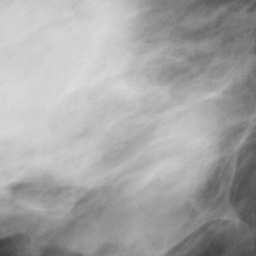

<Figure size 432x288 with 0 Axes>

In [ ]:
img = cv2.imread('/content/gdrive/My Drive/mdb001.pgm')

plt.figure(2)
cv2_imshow(img[512:768,512:768,:])


In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow 

conv_layer = model.get_layer('conv2d_15')
heatmap_model = Model([model.inputs], [conv_layer.output, model.output])

# Get gradient of the winner class w.r.t. the output of the (last) conv. layer
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_15')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

print(heatmap.shape)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((4, 4))
plt.matshow(heatmap)
plt.show()

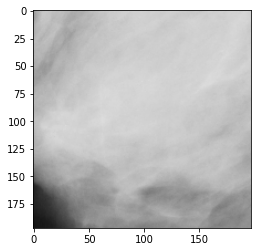

In [ ]:
plt.imshow(img[535:732,425:622])